# Get Rich with Python
## A brief foray in to quantitative finance

This presentation will show you how we used Numpy and Pandas to identify certain trends in S&P Futures timeseries prices and optimized the paramaters of our model to make the most money

## 1) Import the data

### Import data from API and store in CSV for use

In [2]:
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import fix_yahoo_finance as yf

# this is commented out to prevent repeated calls and files saved to disk

# start=datetime.datetime(1998, 11, 9)
# end=datetime.datetime(2018, 6, 25)

# data = data.DataReader('^GSPC', 'yahoo', start, end)

# data.to_csv('S&P 500 Futures Historical Data.csv')

In [3]:
df = pd.read_csv('S&P 500 Futures Historical Data.csv')

# remove the calculated columns
df1 = df[['Date', 'Price', 'Open', 'High', 'Low']]

df1.info()
df1.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Date     5000 non-null object
Price    5000 non-null float64
Open     5000 non-null float64
High     5000 non-null float64
Low      5000 non-null float64
dtypes: float64(4), object(1)
memory usage: 195.4+ KB


,Date,Price,Open,High,Low
0,25-Jun-18,2722.25,2757.00,2758.00,2700.50
1,22-Jun-18,2759.50,2750.50,2768.50,2749.25
2,21-Jun-18,2752.50,2771.75,2785.25,2747.00
3,20-Jun-18,2772.00,2765.25,2778.25,2757.25
4,19-Jun-18,2766.25,2778.25,2780.25,2735.75


Flip data to make the dates in ascending order. This allows for us to apply backward looking rolling windows 

In [4]:
df1 = df1.reindex(index=df1.index[::-1])
df1 = df1.set_index('Date')

df1.head()

,Price,Open,High,Low
Date,,,,
9-Nov-98,1136.5,1146.50,1149.25,1127.50
10-Nov-98,1129.0,1136.25,1140.50,1128.00
11-Nov-98,1126.2,1130.25,1142.00,1121.25
12-Nov-98,1123.8,1126.00,1132.00,1118.25
13-Nov-98,1133.3,1123.50,1134.00,1121.00


## 2) Identify Bollinger Bands
Bollinger Bands are a volatility based indicator. The purpose of Bollinger Bands is to provide a relative definition of high and low prices of a market. By definition, prices are high at the upper band and low at the lower band. If our indicators determine that the security is above or below the limits, then that means that it is either oversold or overbought

Default is a 20-day simple  moving average (SMA) - day length can be changed in the function given

Upper Band = 20-day SMA + (20-day standard deviation of price x 2)

Lower Band = 20-day SMA – (20-day standard deviation of price x 2)

In [5]:
#function to return moving average, standard deviation, upperband, and lowerband 
def bollinger(prices, w=20):
    for i in df1:
        moving_average= prices.rolling(window=w).mean()
        standard_deviation = prices.rolling(window=w).std()
        upper_band = moving_average + (standard_deviation*2) 
        lower_band =  moving_average - (standard_deviation*2)
    return moving_average, standard_deviation, upper_band, lower_band 

In [6]:
df1['Moving_Average'], df1['Standard_Deviation'], df1['Upper_Band'], df1['Lower_Band'] = bollinger(df1['Price'], w=20)  

In [7]:
df1.head(10)

,Price,Open,High,Low,Moving_Average,Standard_Deviation,Upper_Band,Lower_Band
Date,,,,,,,,
9-Nov-98,1136.5,1146.50,1149.25,1127.50,NaN,NaN,NaN,NaN
10-Nov-98,1129.0,1136.25,1140.50,1128.00,NaN,NaN,NaN,NaN
11-Nov-98,1126.2,1130.25,1142.00,1121.25,NaN,NaN,NaN,NaN
12-Nov-98,1123.8,1126.00,1132.00,1118.25,NaN,NaN,NaN,NaN
13-Nov-98,1133.3,1123.50,1134.00,1121.00,NaN,NaN,NaN,NaN
16-Nov-98,1142.3,1134.75,1144.50,1129.75,NaN,NaN,NaN,NaN
17-Nov-98,1143.5,1142.00,1157.50,1132.50,NaN,NaN,NaN,NaN
18-Nov-98,1150.0,1143.50,1151.00,1136.00,NaN,NaN,NaN,NaN
19-Nov-98,1158.7,1149.50,1159.00,1147.25,NaN,NaN,NaN,NaN


### Plot of Bollinger Bands

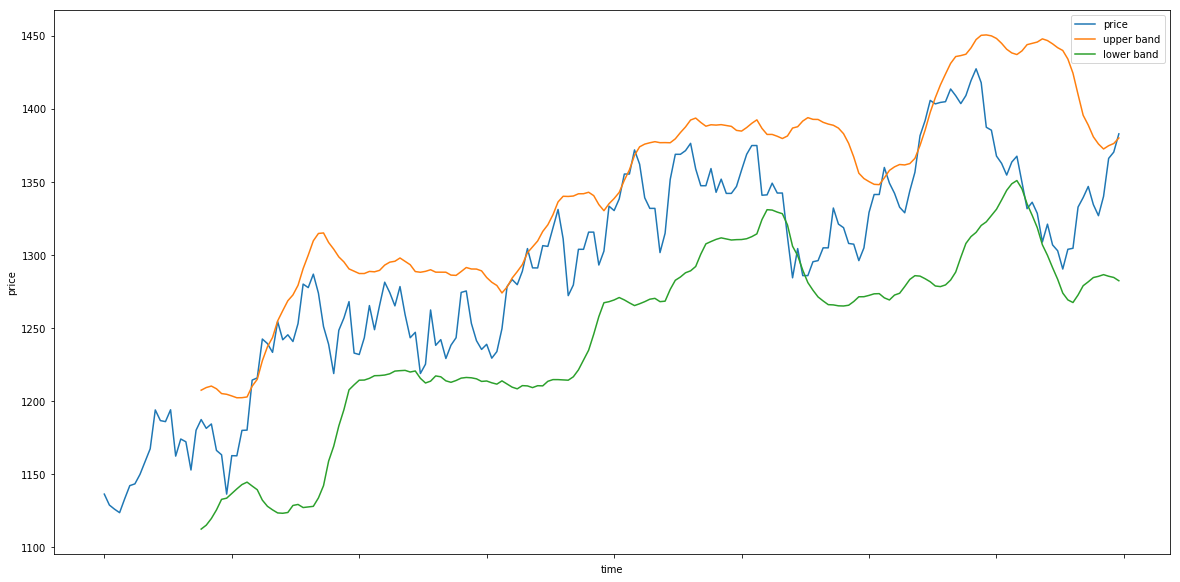

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
df1['Price'][:200].plot(grid=True,label='price')
df1['Upper_Band'][:200].plot(label='upper band')
df1['Lower_Band'][:200].plot(label='lower band')
# ax.set_title()
plt.xlabel('time')
plt.ylabel('price')
# add top and bottom bands to plot
plt.legend()
plt.show()

# 3) Identify the Relative Stength Indicators

The RSI indicator uses the closing prices of completed trading periods to determine who owns the momentum in the market. It assumes that prices close higher in strong market periods (bull markets), and lower in weaker periods (bears owning the scene) and computes this as a ratio of the number of higher closes to the lower closes during a certain period of time

RSI = 100 - 100 / (1 + RS)

Where RS = Average gain of up periods during the specified time frame / Average loss of down periods during the specified time frame

If RSI > 70, sell signal
If RSI < 30, buy signal

In [9]:
df1.head()

,Price,Open,High,Low,Moving_Average,Standard_Deviation,Upper_Band,Lower_Band
Date,,,,,,,,
9-Nov-98,1136.5,1146.50,1149.25,1127.50,NaN,NaN,NaN,NaN
10-Nov-98,1129.0,1136.25,1140.50,1128.00,NaN,NaN,NaN,NaN
11-Nov-98,1126.2,1130.25,1142.00,1121.25,NaN,NaN,NaN,NaN
12-Nov-98,1123.8,1126.00,1132.00,1118.25,NaN,NaN,NaN,NaN
13-Nov-98,1133.3,1123.50,1134.00,1121.00,NaN,NaN,NaN,NaN


In [10]:
# calculate difference of day prices
df1['Diff'] = df1['Price'].diff()

In [11]:
df1.head()

,Price,Open,High,Low,Moving_Average,Standard_Deviation,Upper_Band,Lower_Band,Diff
Date,,,,,,,,,
9-Nov-98,1136.5,1146.50,1149.25,1127.50,NaN,NaN,NaN,NaN,NaN
10-Nov-98,1129.0,1136.25,1140.50,1128.00,NaN,NaN,NaN,NaN,-7.5
11-Nov-98,1126.2,1130.25,1142.00,1121.25,NaN,NaN,NaN,NaN,-2.8
12-Nov-98,1123.8,1126.00,1132.00,1118.25,NaN,NaN,NaN,NaN,-2.4
13-Nov-98,1133.3,1123.50,1134.00,1121.00,NaN,NaN,NaN,NaN,9.5


### Plot the Differences

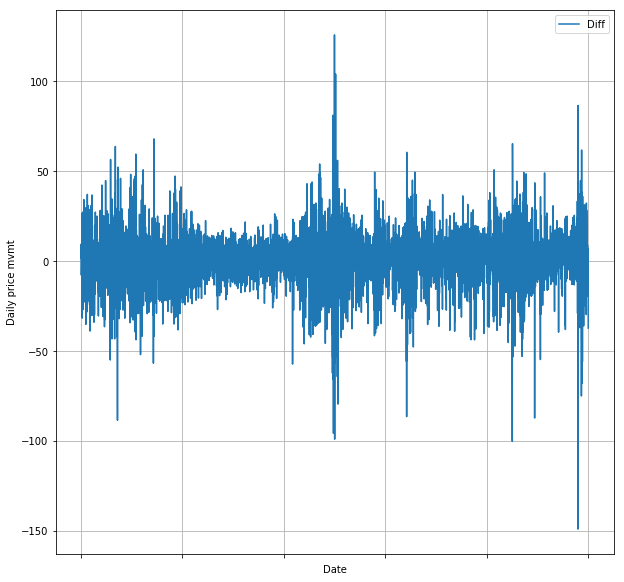

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))

df1['Diff'].plot(grid=True)

plt.ylabel('Daily price mvmt')
plt.legend()
plt.show()

In [14]:
# separating up and down values
df1['Upvals'] = np.where(df1['Diff'] > 0, df1['Diff'], 0)
df1['Downvals'] = np.where(df1['Diff'] < 0, df1['Diff'], 0)
df1.head()

,Price,Open,High,Low,Moving_Average,Standard_Deviation,Upper_Band,Lower_Band,Diff,Upvals,Downvals
Date,,,,,,,,,,,
9-Nov-98,1136.5,1146.50,1149.25,1127.50,NaN,NaN,NaN,NaN,NaN,0.0,0.0
10-Nov-98,1129.0,1136.25,1140.50,1128.00,NaN,NaN,NaN,NaN,-7.5,0.0,-7.5
11-Nov-98,1126.2,1130.25,1142.00,1121.25,NaN,NaN,NaN,NaN,-2.8,0.0,-2.8
12-Nov-98,1123.8,1126.00,1132.00,1118.25,NaN,NaN,NaN,NaN,-2.4,0.0,-2.4
13-Nov-98,1133.3,1123.50,1134.00,1121.00,NaN,NaN,NaN,NaN,9.5,9.5,0.0


In [15]:
# calculate sum of all up or down values divided by length of window
df1['Up'] = df1['Upvals'].rolling(window=20).sum()/20
df1['Down'] = df1['Downvals'].rolling(window=20).sum()/20

In [16]:
# find overall relative strength
df1['RS'] = df1['Up'] / -df1['Down']

In [17]:
# calculate RSI
df1['RSI'] = 100 - (100 / (1 + df1['RS']))

### Plot the RSI

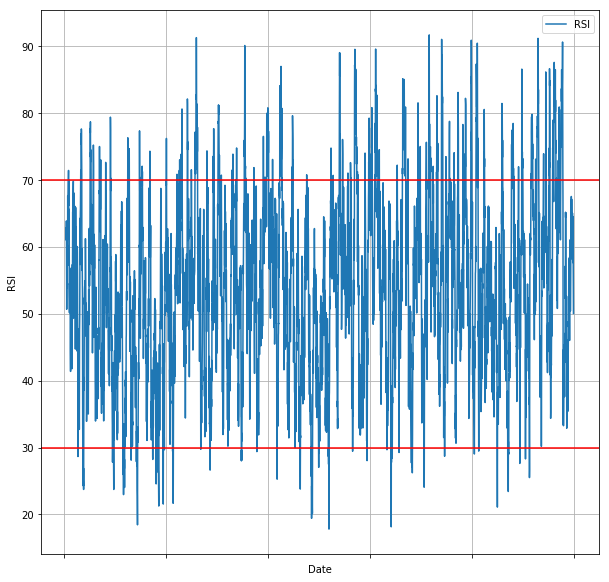

In [19]:
plt.figure(figsize=(10,10))

df1['RSI'].plot(grid=True)
# add top and bottom bands to plot
plt.axhline(y=70, color='r', linestyle='-')
plt.axhline(y=30, color='r', linestyle='-')

plt.ylabel('RSI')
plt.legend()
plt.show()

## 4) Develop trading strategy with model
The trading strategy uses a combination of RSI and Bollinger Bands to generate trading signals to either go LONG or SHORT on the Es mini Futures Index (S&P 500). In very simple terms - When the price goes below the Lower BB and RSI goes below 30 - generates a BUY signal! and when the price goes above the Upper Bollinger Band and RSI goes above 70 - generates a SELL signal!

The hypothesis is that a combination of a momentum indicator (RSI) combined with a volatility based indicactor (Bollinger Bands) will result in profitable trading signals. The strategy below backtests 20 years of data to test this hypothesis

In [20]:
# truncate the dataframe to exclude time before windows are complete. Also reverse the data set 
df_2 = df.iloc[:4981]
df_2= df_2.iloc[::-1] 

In [21]:
# initialize variables
# Key control variables are Profit_taking (% return after which the trade is closed), Stop_loss (negative % return after which the trade is closed and per_capital_deployed ( the amount of capital deployed from the corpus per each trade))
capital = 100000.00
Max_Lots = 8
lot_size = 50
margin_per_lot = 6600
Profit_taking = 0.05
Stop_loss = -0.01
Proximity = 0.05
per_capital_deployed = 0.3

In [22]:
# Define the strategy based on the rules in the description to generate a column called "Signal"
def strategy(row):
    if (row['Price'] > row['BB-upper']*(1-Proximity)) and (row['RSI'] > 70):
        Signal = -1.0
    elif (row['Price'] < row['BB-lower']*(1+Proximity)) and (row['RSI'] < 30):
        Signal = 1.0
    else:
        Signal = 0.0
    return Signal

In [23]:
# Generate the signals in the dataframe
df_2['Signal'] = df_2.apply(strategy, axis=1)  

In [24]:
df_2['Trade']=df_2['Signal']*lot_size*Max_Lots

In [37]:
# Calculating daily percentage change
df_2['Daily_chg']= df_2['Price'].pct_change()
df_2['Daily_chg'].iloc[0]=0.0
df_2
# df_2['Trade'].get_loc(1)
# df_2

df_2.head()

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Date,Price,Open,High,Low,Vol.,Change %,SMA-20,BB-upper,BB-lower,Gain / Loss,Average Gain,Average loss,RS,RSI,Signal,Trade,Daily_chg,Position,Daily_abs_chg
4980,7-Dec-98,1187.5,1180.75,1191.75,1177.25,23.81K,0.62%,"1,160.09",1207.606132,1112.563868,7.3,63.055,-3.680,17.134511,94.485652,-1.0,-400.0,0.000000,-400,0.000000
4979,8-Dec-98,1181.5,1187.25,1195.50,1173.25,28.20K,-0.51%,"1,162.34",1209.413491,1115.256509,-6,6.230,-3.980,1.565327,61.018609,0.0,0.0,-0.005053,0,-5.998737
4978,9-Dec-98,1184.5,1182.00,1187.50,1176.50,27.27K,0.25%,"1,165.11",1210.424986,1119.795014,3,6.380,-3.605,1.769764,63.895844,0.0,0.0,0.002539,0,3.001270
4977,10-Dec-98,1166.4,1185.00,1189.50,1163.75,4.86K,-1.53%,"1,167.12",1208.569404,1125.670596,-18.1,6.380,-4.370,1.459954,59.348837,0.0,0.0,-0.015281,0,-18.107640
4976,11-Dec-98,1163.4,1165.50,1169.50,1154.00,2.49K,-0.26%,"1,169.10",1205.285371,1132.914629,-3,6.380,-4.400,1.450000,59.183673,0.0,0.0,-0.002572,0,-2.997685


In [26]:
# determining size of positions
def position(row):
    if row['Signal'] == 1:
        position = Max_Lots * lot_size*1
        return position
    elif row['Signal'] == -1:
        position = Max_Lots * lot_size * -1
        return position
    else:
        return 0

df_2['Position'] = df_2.apply(position, axis=1)
df_2['Daily_abs_chg'] = df_2['Daily_chg']*df_2['Open']
df_2.head(20)

,Date,Price,Open,High,Low,Vol.,Change %,SMA-20,BB-upper,BB-lower,Gain / Loss,Average Gain,Average loss,RS,RSI,Signal,Trade,Daily_chg,Position,Daily_abs_chg
4980,7-Dec-98,1187.50,1180.75,1191.75,1177.25,23.81K,0.62%,"1,160.09",1207.606132,1112.563868,7.3,63.055,-3.680,17.134511,94.485652,-1.0,-400.0,0.000000,-400,0.000000
4979,8-Dec-98,1181.50,1187.25,1195.50,1173.25,28.20K,-0.51%,"1,162.34",1209.413491,1115.256509,-6,6.230,-3.980,1.565327,61.018609,0.0,0.0,-0.005053,0,-5.998737
4978,9-Dec-98,1184.50,1182.00,1187.50,1176.50,27.27K,0.25%,"1,165.11",1210.424986,1119.795014,3,6.380,-3.605,1.769764,63.895844,0.0,0.0,0.002539,0,3.001270
4977,10-Dec-98,1166.40,1185.00,1189.50,1163.75,4.86K,-1.53%,"1,167.12",1208.569404,1125.670596,-18.1,6.380,-4.370,1.459954,59.348837,0.0,0.0,-0.015281,0,-18.107640
4976,11-Dec-98,1163.40,1165.50,1169.50,1154.00,2.49K,-0.26%,"1,169.10",1205.285371,1132.914629,-3,6.380,-4.400,1.450000,59.183673,0.0,0.0,-0.002572,0,-2.997685
4975,14-Dec-98,1136.50,1161.00,1161.00,1135.50,2.49K,-2.31%,"1,169.26",1204.801430,1133.718570,-26.9,5.905,-5.745,1.027850,50.686695,0.0,0.0,-0.023122,0,-26.844507
4974,15-Dec-98,1162.80,1137.50,1164.00,1137.00,1.67K,2.31%,"1,170.29",1203.669666,1136.900334,26.3,6.770,-5.745,1.178416,54.095086,0.0,0.0,0.023141,0,26.323141
4973,16-Dec-98,1162.70,1163.25,1168.75,1138.00,1.05K,-0.01%,"1,171.25",1202.417557,1140.072443,-0.1,6.710,-5.750,1.166957,53.852327,0.0,0.0,-0.000086,0,-0.100039
4972,17-Dec-98,1180.10,1165.25,1183.00,1140.00,0.84K,1.50%,"1,172.75",1202.476720,1143.023280,17.4,7.255,-5.750,1.261739,55.786236,0.0,0.0,0.014965,0,17.438161
4971,18-Dec-98,1180.28,1181.50,1182.50,1177.00,0.22K,0.02%,"1,173.83",1202.969255,1144.688745,0.18,6.829,-5.750,1.187652,54.288894,0.0,0.0,0.000153,0,0.180214


In [27]:
# Max number of lots initially
l = int(capital / margin_per_lot)
l

15

### Find out how much money we're making

In [28]:
# defining profit dunction with dataframe and other inputs
def profit(df_2,profit_taking,Stop_loss,per_capital_deployed):
    entry_price = 0
    exit_price = 0
    current_profit = 0 
    trade_stoploss = np.inf
    trade_profitreshold = np.inf 
    total_profit = 0
    record = list()
    in_trade = False 
    trade_type = 'none'
    
    lots_traded = int (capital* per_capital_deployed / margin_per_lot)

    # itereating through DF for buy/sell signals
    for row in df_2.itertuples(): 
        # if there is no standing position in portfolio
        # looking for opportunities
        if not in_trade:
            
            # BUY scenario
            if row.Signal == 1:
                entry_price = row.Price
                trade_stoploss = row.Price*Stop_loss
                trade_profitreshold = row.Price*profit_taking
                trade_type = 'long'
                in_trade = True
            # SELL scenario
            elif row.Signal ==-1: 
                entry_price = row.Price
                trade_stoploss = -row.Price *Stop_loss
                trade_profitreshold = -row.Price *profit_taking
                trade_type = 'short'
                in_trade = True
#                 print(f'Selling {lots_traded} lots on {row.Date}, price: {row.Price} and trade type is {trade_type}')
       
    # Portfolio has ongoing position
        else: 
            current_profit +=  (row.Daily_abs_chg )
            lots_traded = round((capital+total_profit)*per_capital_deployed / margin_per_lot,0)
#             print(f'Current profit is {current_profit} and profit treshhold per share is {trade_profitreshold} and stoploss is {trade_stoploss}')
            
            # looking at ongoing Short position
            if trade_type == 'short':
                # exit if over profit threshold
                if current_profit <= trade_profitreshold:
                    total_profit += -(trade_profitreshold * lots_traded * lot_size)
#                     print(f'Exiting {trade_type} on {row.Date}, price: {row.Price}, profit is {total_profit}')        
                    record.append({'entry price':entry_price, 'exit price':row.Price, 'gain_loss':current_profit, 'trade_type':trade_type})
                    current_profit = 0 
                    entry_price = 0
                    trade_stoploss = np.inf
                    trade_profitreshold = np.inf
                    trade_type = 'none'
                    in_trade = False
                    
                    # exit if over stoploss
                elif current_profit>= trade_stoploss:
                    total_profit += -trade_stoploss* lots_traded * lot_size
#                     print(f'Exiting {trade_type} on {row.Date}, price: {row.Price}, profit is {total_profit}')        
                    record.append({'entry price':entry_price, 'exit price':row.Price, 'gain_loss':current_profit, 'trade_type':trade_type})
                    current_profit = 0 
                    entry_price = 0
                    trade_stoploss = np.inf
                    trade_profitreshold = np.inf
                    trade_type = 'none'
                    in_trade = False
                    
                    # same as above for long position
            elif trade_type == 'long':
                if current_profit >= trade_profitreshold: 
                    total_profit += trade_profitreshold* lots_traded * lot_size
#                     print(f'Exiting {trade_type} on {row.Date}, price: {row.Price}, profit is {total_profit}')        
                    record.append({'entry price':entry_price, 'exit price':row.Price, 'gain_loss':current_profit, 'trade_type':trade_type})
                    current_profit = 0 
                    entry_price = 0
                    trade_stoploss = np.inf
                    trade_profitreshold = np.inf
                    trade_type = 'none'
                    in_trade = False

                elif current_profit<= trade_stoploss: 
                    total_profit += trade_stoploss* lots_traded * lot_size
#                     print(f'Exiting {trade_type} on {row.Date}, price: {row.Price}, profit is {total_profit}')        
                    record.append({'entry price':entry_price, 'exit price':row.Price, 'gain_loss':current_profit, 'trade_type':trade_type})
                    current_profit = 0 
                    entry_price = 0
                    trade_stoploss = np.inf
                    trade_profitreshold = np.inf
                    trade_type = 'none'
                    in_trade = False
                

    return total_profit
profit(df_2, Profit_taking, Stop_loss, per_capital_deployed)

395653.635

## 5) Optimize variables and parameters

In [41]:
# Creating independent variables to run a sensitivity analysis on:
# Also recording max profit and optimal conditions

# where should the stoploss, profit, and capital deployed be set
# loop through 1000 scenarios to find most overall profit
Profit_Threshold_list = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
Stoploss_Threshold_list = [-.1,-0.09,-0.08,-0.07,-0.06,-0.05,-0.04,-0.03,-0.02,-0.01]
Capital_deployed_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
max_profit = 0
temp = 0
P_t = 0
S_L = 0
C_D = 0
Pnl = list()
for P in Profit_Threshold_list:
    for S in Stoploss_Threshold_list:
        for C in Capital_deployed_list:
            temp = profit(df_2,P,S,C)
            if temp > max_profit:
                max_profit = temp
                P_T = P
                S_L = S
                C_D = C
            Pnl.append(temp)

            # output is list of all overall profits scenarios

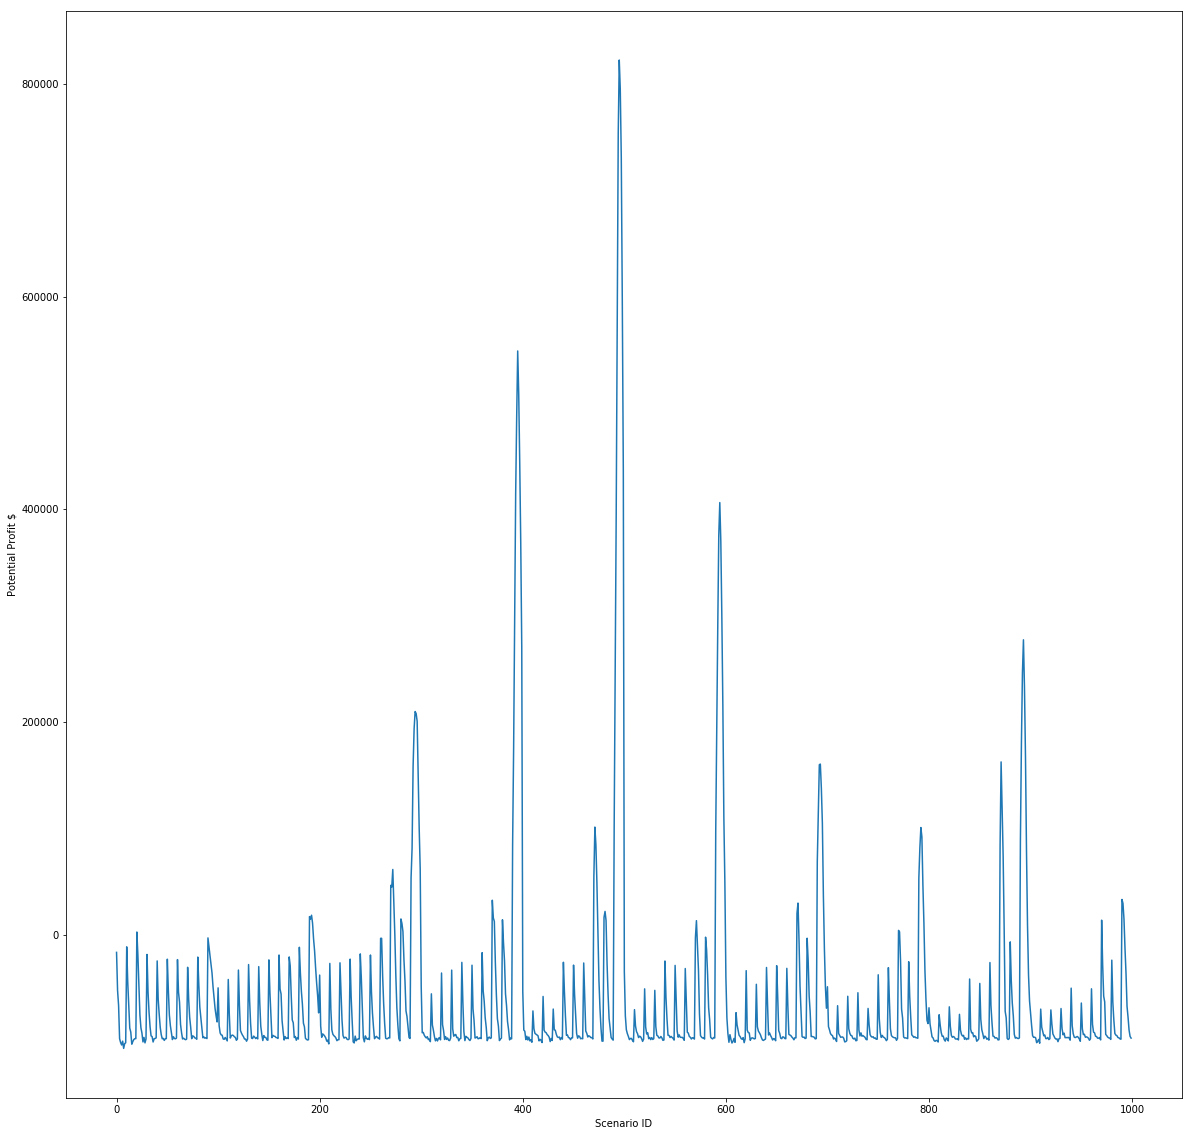

In [35]:
# Plot the P&L list
%matplotlib inline

plt.figure(figsize=(20,20))

plt.ylabel('Potential Profit $')
plt.xlabel('Scenario ID')

plt.plot(Pnl)
plt.show()

In [36]:
# Printing Optimized Results:
print(f'FINAL RESULTS:')
print(f'The max profit is {max_profit}')
print (f'The max annualized rate of return is {((max_profit + 100000)/100000)**(1/20)-1}')
print (f'The optimal Profit Threshold is {P_T}')
print(f'The optimal Stoploss Threshold is {S_L}')
print (f'The optimal capital deployed per trade is {C_D}')

FINAL RESULTS:
The max profit is 822254.5600000005
The max annualized rate of return is 0.11748715691417266
The optimal Profit Threshold is 0.05
The optimal Stoploss Threshold is -0.01
The optimal capital deployed per trade is 0.6
